# $\text{Jane Street Market Prediction}$

## $\text{Getting the data}$

## For Oscar:

In [1]:
# Data
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500) #arbitrary large number, I wanna see all columns


# Plotting
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

#utilities
import os
from collections import Counter

In [2]:
%%time
working_dir = "/Users/oscarengelbrektson/Documents/Minerva/Spring 2021 - San Francisco/Quantitative Trading/Jane Street Competition/data/"

train_data = pd.read_csv(working_dir + "train.csv")
test_data_sample = pd.read_csv(working_dir + "example_test.csv")
feature_data = pd.read_csv(working_dir + "features.csv")


CPU times: user 53.7 s, sys: 5.26 s, total: 59 s
Wall time: 59.3 s


## For Taha

In [1]:
# getting access to Google Drive to retrieve data
#from google.colab import drive
#drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# changing the working directory
#%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


In [3]:
'''
!kaggle competitions download -c jane-street-market-prediction
!unzip \*.zip  && rm *.zip''';

In [7]:
%%time
train_data = pd.read_csv('C:/Users/Taha/Desktop/Spring 2021/JaneStreet/train.csv')

Wall time: 2min 7s


In [9]:
# difference columns between train and test set
#set(train_data.columns) - set(test_sample.columns)

## $\text{LightGMB}$

### $\text{Data Processing}$

In [3]:
#Get outcome variable by transforming resp > 0
train_data["action"] = train_data["resp"].apply(lambda x: int(x>0))

In [6]:
#Train-validation-test split : 300-100-100
train_set = train_data[train_data.date < 300]
validation_set = train_data[(train_data.date >= 300) & (train_data.date < 400)]
test_set = train_data[train_data.date >= 400]

train_set.date.nunique(), validation_set.date.nunique(), test_set.date.nunique()

(300, 100, 100)

In [7]:
# percentage of trades in the test set
round(100*validation_set.shape[0] / (train_data.shape[0]), 2)

19.88

In [8]:
predictors = list(set(train_data.columns) - {'resp', 'resp_1', 'resp_2', 'resp_3', 'resp_4', 'action', 'ts_id'})
outcome = ['action']

In [12]:
X_train, X_validation, y_train, y_validation = train_set[predictors],  validation_set[predictors], train_set[outcome], validation_set[outcome]
X_test, y_test = test_set[predictors], test_set[outcome]

### $\text{LightGBM: One Split}$

In [13]:
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix
import lightgbm as lgb

In [15]:


#print(X_train.shape, X_validation.shape, y_train.shape, y_validation.shape)

lgb_model = lgb.LGBMClassifier()
lgb_model.fit(X_train, y_train.values.reshape(len(y_train),), verbose=True)

LGBMClassifier()

In [16]:
y_pred = lgb_model.predict(X_validation)

In [17]:
print("Accuracy of model is: ", accuracy_score(y_validation, y_pred))

Accuracy of model is:  0.5135959448429915


In [18]:
print('Training set score: {:.4f}'.format(lgb_model.score(X_train, y_train)))
print('Test set score: {:.4f}'.format(lgb_model.score(X_validation, y_validation)))

Training set score: 0.5597
Test set score: 0.5136


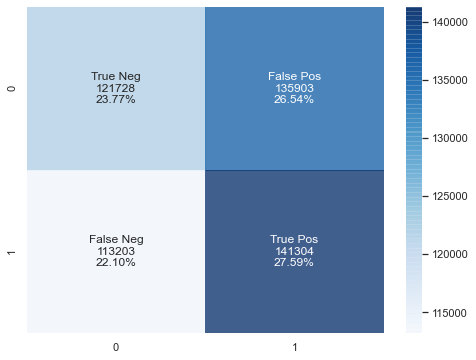

In [19]:
import seaborn as sns

def plot_cm(cm):
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
              zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.set(rc={'figure.figsize':(8, 6)})
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', alpha=.75)
    
plot_cm(confusion_matrix(y_validation, y_pred));

### $\text{Hyperparameter Tunning: Bayesian Optimization}$

In [14]:
def lgbm_cv(learning_rate, num_leaves, 
            min_data_in_leaf, max_bin,
            max_depth):
    
    estimator_function = lgb.LGBMClassifier(max_depth=int(max_depth),
                                            learning_rate = learning_rate,
                                            num_leaves = int(num_leaves),
                                            min_data_in_leaf = int(min_data_in_leaf),
                                            max_bin=int(max_bin),
                                            objective = 'binary', 
                                            boosting= 'gbdt',
                                            nthread=10,
                                            seed = 42,
                                            verbose = -1)
    
    estimator_function.fit(X_train, y_train.values.reshape(len(y_train),))
    probs = estimator_function.predict_proba(X_validation)[:,1]
    return roc_auc_score(y_validation, probs)

In [15]:
from bayes_opt import BayesianOptimization

gp_params = {"alpha": 1e-10}

hp_space = {'learning_rate': (0.001, 0.1),
          'num_leaves': (100, 300),
          'min_data_in_leaf': (5, 20),
          'max_bin': (150, 250),
          'max_depth': (2, 15)}

lgbcBO = BayesianOptimization(f=lgbm_cv, pbounds=hp_space, random_state=42, verbose=-1)

In [16]:
lgbcBO.maximize(init_points=5, n_iter=20, acq='ucb', kappa= 3, **gp_params)

|   iter    |  target   | learni... |  max_bin  | max_depth | min_da... | num_le... |
-------------------------------------------------------------------------------------
[LightGBM] [Warning] num_threads is set with nthread=10, will be overridden by n_jobs=-1. Current value: num_threads=-1
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
|  1        |  0.5189   |  0.03808  |  245.1    |  11.52    |  13.98    |  131.2    |
[LightGBM] [Warning] num_threads is set with nthread=10, will be overridden by n_jobs=-1. Current value: num_threads=-1
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
|  2        |  0.5195   |  0.01644  |  155

|  17       |  0.5164   |  0.01722  |  160.1    |  5.093    |  18.68    |  259.0    |
[LightGBM] [Warning] num_threads is set with nthread=10, will be overridden by n_jobs=-1. Current value: num_threads=-1
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
|  18       |  0.5179   |  0.03093  |  156.7    |  14.93    |  13.53    |  241.7    |
[LightGBM] [Warning] num_threads is set with nthread=10, will be overridden by n_jobs=-1. Current value: num_threads=-1
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
|  19       |  0.5187   |  0.09406  |  243.7    |  11.65    |  14.91    |  132.5    |
[LightGBM] [Warning] num_threads is set wi

In [17]:
#Best accuracy:
lgbcBO.max["target"]

0.5204235055762242

In [18]:
best_params = lgbcBO.max["params"]
best_params

{'learning_rate': 0.06175204549719997,
 'max_bin': 156.30186003381468,
 'max_depth': 10.781108106324954,
 'min_data_in_leaf': 12.416899494524063,
 'num_leaves': 242.86754316257662}

## Train model with best hyperparameters on train set

In [20]:
validated_lgbm_model = lgb.LGBMClassifier(max_depth=int(round(best_params["max_depth"])),
                                            learning_rate = best_params["learning_rate"],
                                            num_leaves = int(round(best_params["num_leaves"])),
                                            min_data_in_leaf = int(round(best_params["min_data_in_leaf"])),
                                            max_bin=int(round(best_params["max_bin"])),
                                            objective = 'binary', 
                                            boosting= 'gbdt',
                                            nthread=10,
                                            seed = 42,
                                            verbose = -1)

In [21]:
validated_lgbm_model.fit(train_set[predictors],
                     train_set[outcome].values.reshape(len(train_set),), 
                     verbose=True)

[LightGBM] [Warning] num_threads is set with nthread=10, will be overridden by n_jobs=-1. Current value: num_threads=-1
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


LGBMClassifier(boosting='gbdt', learning_rate=0.06175204549719997, max_bin=156,
               max_depth=11, min_data_in_leaf=12, nthread=10, num_leaves=243,
               objective='binary', seed=42, verbose=-1)

# Compute utility score depending on decision threshold'

In [22]:
y_pred_probs = validated_lgbm_model.predict_proba(X_validation)

In [23]:
validation_set["lgbm_predicted_prob"] = y_pred_probs[:, 1] #Probability of target=1

<ipython-input-23-9d3c100330eb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_set["lgbm_predicted_prob"] = y_pred_probs[:, 1] #Probability of target=1


In [24]:
def utility_score_last(date, weight, resp, action):
    '''
    Takes four 1-d arrays of equal size:
    Date: int
    weight: float >= 0
    resp: float
    action: binary
    
    and returns jane street utility score, u
    '''
    count_i = date.nunique() # Get number of days
    P_i = np.bincount(date, weight * resp * action) # Compute P_i
    t = np.sum(P_i) / np.sqrt(np.sum(P_i ** 2)) * np.sqrt(250 / count_i) # Compute t
    u = np.clip(t, 0, 6) * np.sum(P_i) # Combine to get utility score
    return u

def get_utility_from_df(df, decision_threshold=0.5):
    '''
    Takes a dataframe and a decision threshold, 
    computes the total utility given the decision threshold for converting predicted probabilities to actions
    '''
    return utility_score_last(df.date, df.weight, df.resp, 
                              df.lgbm_predicted_prob.apply(lambda proba: int(proba > decision_threshold)))

In [25]:
thresholds =  np.linspace(0, 1, 200)
utility_by_threshold = [get_utility_from_df(validation_set, threshold) for threshold in thresholds]

<ipython-input-24-1f5466e7d848>:13: RuntimeWarning: invalid value encountered in double_scalars
  t = np.sum(P_i) / np.sqrt(np.sum(P_i ** 2)) * np.sqrt(250 / count_i) # Compute t


In [26]:
best_threshold = thresholds[utility_by_threshold.index(max(utility_by_threshold))]

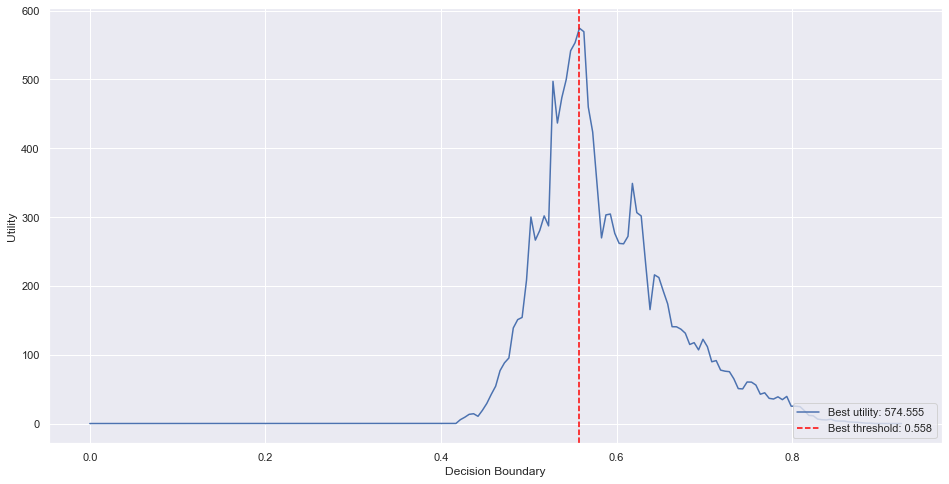

In [27]:
# Visualize
plt.figure(figsize=(16, 8))
plt.plot(thresholds, utility_by_threshold, label="Best utility: %s"%np.round(max(utility_by_threshold), 3))
plt.axvline(best_threshold, 
            color="red", linestyle="--",label="Best threshold: %s"%np.round(best_threshold, 3))
plt.ylabel("Utility")
plt.xlabel("Decision Boundary")
plt.legend(loc=4)
plt.show()

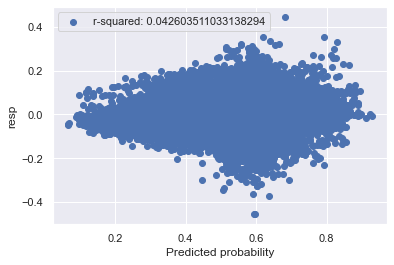

In [28]:
plt.scatter(validation_set.lgbm_predicted_prob, validation_set.resp, label="r-squared: {}".format(np.corrcoef(validation_set.lgbm_predicted_prob,
                                                                                             validation_set.resp)[0,1]))
plt.xlabel("Predicted probability")
plt.ylabel("resp")

plt.legend(loc=0)
plt.show()

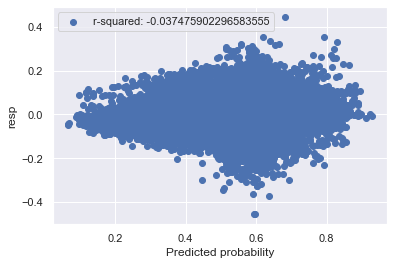

In [29]:
plt.scatter(validation_set.lgbm_predicted_prob, validation_set.resp, label="r-squared: {}".format(np.corrcoef(validation_set.lgbm_predicted_prob,
                                                                                             validation_set.weight)[0,1]))
plt.xlabel("Predicted probability")
plt.ylabel("resp")

plt.legend(loc=0)
plt.show()

# Train best model on entire train + validation dataset before running on test

In [30]:
#Merge train and validation data into a single dataframe
validation_set.drop(columns=["lgbm_predicted_prob"], axis=1, inplace=True)
train_and_validation_set = pd.concat([train_set, validation_set], axis=0)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [31]:
#Define model with best hyperparameters based on validation set
final_lgbm_model = lgb.LGBMClassifier(max_depth=int(round(best_params["max_depth"])),
                                            learning_rate = best_params["learning_rate"],
                                            num_leaves = int(round(best_params["num_leaves"])),
                                            min_data_in_leaf = int(round(best_params["min_data_in_leaf"])),
                                            max_bin=int(round(best_params["max_bin"])),
                                            objective = 'binary', 
                                            boosting= 'gbdt',
                                            nthread=10,
                                            seed = 42,
                                            verbose = -1)

In [33]:
#Train on merged dataset
final_lgbm_model.fit(train_and_validation_set[predictors],
                     train_and_validation_set[outcome].values.reshape(len(train_and_validation_set),), 
                     verbose=True)

[LightGBM] [Warning] num_threads is set with nthread=10, will be overridden by n_jobs=-1. Current value: num_threads=-1
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


LGBMClassifier(boosting='gbdt', learning_rate=0.06175204549719997, max_bin=156,
               max_depth=11, min_data_in_leaf=12, nthread=10, num_leaves=243,
               objective='binary', seed=42, verbose=-1)

### Save model as pickle file to avoid having to retrain

In [76]:
import joblib
# save model
#joblib.dump(final_lgbm_model, 'final_lgbm_model1.pkl')
# load model
gbm_pickle = joblib.load('final_lgbm_model1.pkl')

In [77]:
gbm_pickle

LGBMClassifier(boosting='gbdt', learning_rate=0.06175204549719997, max_bin=156,
               max_depth=11, min_data_in_leaf=12, nthread=10, num_leaves=243,
               objective='binary', seed=42, verbose=-1)

# Compute test set utility

In [78]:
y_preds = gbm_pickle.predict_proba(X_test)

In [79]:
test_set["lgbm_predicted_prob"] = y_preds[:, 1]

<ipython-input-79-ff5a00e50ae4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set["lgbm_predicted_prob"] = y_preds[:, 1]


In [81]:
get_utility_from_df(test_set, best_threshold)

1253.174374868621

# Abandoned approach using TimeSeriesSplit:
Abandoned because was not computationally feasible, would shortcircuit my computers RAM when we tried to use it for hyperparameter selection

In [10]:
from sklearn.model_selection import TimeSeriesSplit

#Number of trades in each split, with TimeSeriesSplit
X_train, y_train = train_set[predictors], train_set[outcome]
ts = TimeSeriesSplit(n_splits=4)
for i in ts.split(X_train, y_train):
    print(len(i[0]), len(i[1]))

280617 280613
561230 280613
841843 280613
1122456 280613


In [11]:
#Number of dates in each split, with TimeSeriesSplit

ts = TimeSeriesSplit(n_splits=4)
for fold_index, holdout_index in ts.split(X_train, y_train):     
    X_fold, X_holdout = X_train.iloc[fold_index,:].date.nunique(), X_train.iloc[holdout_index,:].date.nunique()
    print('Train: {}, Test: {}'.format(X_fold, X_holdout))

Train: 44, Test: 53
Train: 96, Test: 75
Train: 170, Test: 68
Train: 237, Test: 64


In [ ]:
import gc

n_folds = 4
folds = TimeSeriesSplit(n_splits=n_folds)

splits = folds.split(train_set[predictors], train_set[outcome])

y_preds = np.zeros(validation_set.shape[0])
y_oof = np.zeros(train_set.shape[0])
mean_score = []

feature_importances = pd.DataFrame()
feature_importances['feature'] = predictors

for fold_n, (train_index, valid_index) in enumerate(splits):

    print('Fold:', fold_n+1)
    
    X_train, X_valid = train_set[predictors].iloc[train_index], train_set[predictors].iloc[valid_index]
    y_train, y_valid = train_set[outcome].iloc[train_index], train_set[outcome].iloc[valid_index]

    d_train = lgb.Dataset(X_train, label=y_train)
    d_valid = lgb.Dataset(X_valid, label=y_valid)

    model = lgb.train(params, d_train, 2500, valid_sets = [d_train, d_valid], early_stopping_rounds = 50, verbose_eval=100)
    
    feature_importances[f'fold_{fold_n + 1}'] = model.feature_importance()

    y_pred_valid = np.round(model.predict(X_valid, num_iteration=model.best_iteration))

    y_oof[valid_index] = y_pred_valid
    
    val_score = accuracy_score(y_pred_valid, y_valid)

    print(f'val AUC score is {val_score}')

    mean_score.append(val_score)

    y_preds += model.predict(validation_set[predictors], num_iteration=model.best_iteration) / n_folds

    del X_train, X_valid, y_train, y_valid
    gc.collect()

print('AUC score over folds is', np.mean(mean_score))

#test['demand'] = y_preds

In [ ]:
# Parameters for lightGBM. Objective is minimizing logloss
params = {'learning_rate': 0.01,
          'boosting': 'gbdt',
          'objective': 'binary',
          'num_leaves': 200,
          'min_data_in_leaf': 10,
          'max_bin': 200,
          'max_depth': 6,
          'seed': 2018,
          'nthread': 10}